In [1]:
import numpy as np
import pylab as p
import scipy.integrate  as  ode
import matplotlib.pyplot  as  plt
import math
import timeit

np.set_printoptions(linewidth = 130, precision = 13)
%matplotlib inline

from scipy.optimize import fsolve
from scipy import integrate

In [3]:
#create main parameters
def parameters(n):
    
    #m, beta, b, k
    m = np.random.rand(1)/np.random.rand(1)
    gamm = 10*(np.random.rand(1) - np.random.rand(1))
    if gamm > m:
        temp1 = m
        m = gamm
        gamm = temp1 #make sure that r = m - gamma > 0
    
    
    beta = 10*np.random.rand(1)
    if m > beta:
        temp2 = m
        m = beta
        beta = temp2 #make sure that m < beta
    
    b = (np.random.rand(n) - np.random.rand(n))*10

    nu1d = (np.random.rand(n) - np.random.rand(n))*10
    nu2d = (np.random.rand(n, n) - np.random.rand(n, n))*10

    k = np.random.rand(1)*10
    alp = (np.random.rand(n, n) - np.random.rand(n, n))*10
    
    #S*, T*, I*, J* and determinant of matrix
    S_star = m/beta
    T_star = 1 - S_star
    I_star = m*T_star/(m + beta*k*T_star)
    J_star = T_star - I_star

    detP = -I_star*J_star + 2*(T_star)**2
    
#coefficients for replicator equations: theta 1,2,3,4 and big-theta
    teth1 = 2*S_star*(T_star)**2/detP
    teth2 = I_star*(I_star + T_star)/detP
    teth3 = T_star*J_star/detP
    teth4 = beta*T_star*J_star/detP

    Teth = teth1 + teth2 + teth3 + teth4

    #fitness matrix
    lamd = np.zeros((n,n))
    for i in range (0,n):
        for j in range (0,n):
            lamd[i][j] = teth1*(b[i] - b[j]) + teth2*(- nu1d[i] + nu1d[j]) + teth3*( - nu2d[i][j] - nu2d[j][i] + 2*nu2d[j][j]) + teth4*(I_star/J_star*(alp[j][i] - alp[i][j]) + alp[j][i] - alp[j][j])


    coeffs = np.array([m, b, beta, gamm, nu1d, nu2d, k, alp, lamd, S_star, T_star, I_star, J_star, Teth])
    return(coeffs)

In [4]:
#create initial values
def initial(n):
    #random initial data for RE system
    u0 = np.random.random(n)
    u0 = u0/sum(u0)
    
    #random initial data for original quasi neutral SIS system
    I_i0 = u0*I_star #initial value for I_i
    
    I_ij_sq = np.zeros((n,n)) #initial value for I_ij
    for i in range (0, n):
        for j in range (0, n):
            I_ij_sq[i][j] = k*I_star*T_star/S_star*u0[i]*u0[j]
            
    I_ij0 = np.reshape(I_ij_sq, n*n)
    
    S0 = m/beta #initial values S
    
    #reshape the initial values into a vector
    X0 = np.zeros(n*n + n + 1)
    for i in range (0 , n*n ):
        X0[i] = I_ij0[i]
    for i in range (n*n, n*n + n):
        X0[i] = I_i0[i - n*n]
    X0[n*n + n] = S0
    return u0, X0

In [25]:
#subprogram computing RE system
def RE(n):   
    def du_dt(u, t = 0):
        return Teth*u*(np.dot(lamd,u) - np.dot(np.dot(lamd,u),u))
               
    t = np.linspace(0, 1, 20)
    
    #solve and compute the time
    start = timeit.default_timer()
    u, infodict = integrate.odeint(du_dt, u0, t, full_output=True)
    infodict['message']
    stop = timeit.default_timer()
    
    #solution at time 100
    sol_re = u.T[:,-1]
    
    return(sol_re, stop - start)

In [26]:
#compute the essential parameters for original quasi-neutral SIS system
#create the matrix of symmetric coefficients
def sym(n):
    A = np.random.random((n,n))
    sym = (A.T - A)*10
    return sym

#lamda matrix of force infection for each strain
def lambd_rate(X):
    lambd = np.zeros(n)
    temp = X[0: n*n]
    Y = temp.reshape(n, n)
    for i in range (0, n):
            lambd[i] = (beta + eps*b[i])*(X[n*n + i - 1] + np.dot(1/2 + eps*symm[i,:], Y[i,:]) + np.dot(1/2 + eps*symm[:,i], Y[:,i]))
    return lambd

In [27]:
def solveSIS(n):
    # The original quasi neutral SIS system
    def SIS(X, t = 0):
        deriv = np.zeros(n*n + n + 1)
        
        # 1st part: equations for I_ij
        Y = X[0: n*n]
        I_ij = Y.reshape(n,n)
        I_i = X[n*n: n*n + n]
        
        Z = k*(1 + eps*alp)*np.matmul(I_i, lambd_rate(X))- (m + eps*nu2d)*I_ij
        Z_new = Z.reshape(n*n)
        for i in range (0, n*n):
            deriv[i] = Z_new[i]
        
        #2nd part: equations for I_i
        temp = X[-1]*lambd_rate(X) - (m + eps*nu1d)*I_i - I_i*(np.dot(k + eps*alp, lambd_rate(X)))
        for i in range (n*n, n*n + n):
            deriv[i] = temp[i - n*n]
        
        #3rd part: equation for S
        deriv[-1] = (m - gamm)*(1 - X[-1]) + np.dot(gamm + eps*nu1d, I_i) + np.sum((gamm + eps*nu2d)* I_ij) - X[-1]*np.dot(np.ones(n), lambd_rate(X))
        return deriv
    
    t = np.linspace(0, 10, 200)
    
    start = timeit.default_timer()
    X, infodict = integrate.odeint(SIS, X0, t, full_output=True)
    infodict['message']
    stop = timeit.default_timer()
    sol_or = X.T[:,-1]
    
    return(sol_or, stop - start)

In [32]:
nstrain = [2, 3, 4, 5, 6, 7, 8, 9, 10]
eps = 0.1
err = []

t_RE = []
t_SIS = []

for n in nstrain:
    # Invoke the parameters
    m, b, beta, gamm, nu1d, nu2d, k, alp, lamd, S_star, T_star, I_star, J_star, Teth = parameters(n)
    symm = sym(n)
    
    u0, X0 = initial(n)
    #solve two systems
    sol_re, t1 = RE(n)
    sol_or, t2 = solveSIS(n)
    
    # Compute times of two progresses
    t_RE.append(t1)
    t_SIS.append(t2)

    #compute the error between solution of the original system and the replicator system
    #separte solution to parts: I_i, I_ij
    Y = sol_or[0: n*n]
    I_ij = Y.reshape(n,n)
    I_i = sol_or[n*n: n*n + n]
    
    #reconstruct approximation of I_ij from u_i
    u_ij = np.zeros((n,n))
    for i in range (0, n):
        for j in range (0, n):
            u_ij[i][j] = sol_re[i]*sol_re[j]
    #error
    err_cell = np.linalg.norm(sol_or[-1] - S_star) + np.linalg.norm(I_i - I_star*sol_re) + np.linalg.norm(I_ij - (I_star*T_star/S_star)*u_ij)
    err.append(err_cell)

Text(0.5, 1.0, 'Error $\\epsilon = 0.1$ with $T = 100$')

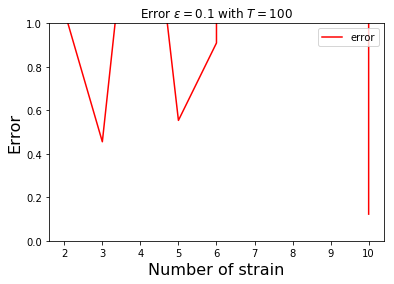

In [34]:
#plotting the error due to the number of strains at time T = 100
f1 = plt.figure()
plt.plot(nstrain, err, 'r-', label='error')

plt.legend(loc='best')
plt.xlabel("Number of strain", fontsize=16)
plt.ylabel("Error", fontsize = 16)
plt.ylim(0, 1)
plt.title("Error $\epsilon = 0.1$ with $T = 100$")

Text(0, 0.5, 'Timing of progress')

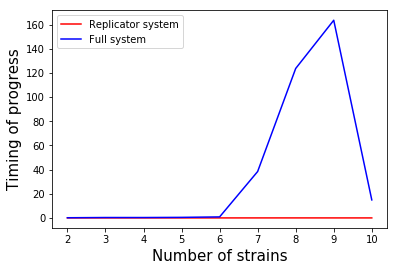

In [35]:
#plotting the time
f2 = plt.figure(figsize=(6, 4))

plt.plot(nstrain, t_RE, 'r', label = 'Replicator system')
plt.plot(nstrain, t_SIS, 'b', label = 'Full system')

plt.legend(loc='best')
plt.xlabel("Number of strains", fontsize=15)
plt.ylabel("Timing of progress", fontsize = 15)